# Random Walker Segmentation in Python (When Histogram Thresholding Fails)
*Denoise → Improve contrast → Place confident markers → Random Walker diffusion → Clean + visualize*

---

## Why Random Walker?

In the previous tutorial we used **histogram-based segmentation** successfully because different regions had **well-separated intensity peaks**.

But images often look like this:

- Two (or more) visually distinct regions exist…
- Yet their pixel intensities **overlap heavily**
- Thresholds either under-segment or mix phases

In these cases, **Random Walker segmentation** is a strong next tool because:

✅ You provide a few **high-confidence “markers”** (seed regions)  
✅ The algorithm assigns every unlabeled pixel to the most likely region by solving a diffusion problem  
✅ It works well even when intensities overlap—as long as the seeds are correct

In `scikit-image`, Random Walker lives in:

In [1]:
from skimage.segmentation import random_walker

**Overview of the Pipeline**
We’ll build an end-to-end workflows:
1. Load image (float)
2. Check histogram (confirm thresholding is not enough)
3. Denoise (Non-Local Means)
4. Improve contrast (CLAHE / adaptive histogram equalization)
5. Build marker map (0=unknown, 1=phase A, 2=phase B)
6. Run random walker
7. Convert labels into masks and a colored overlay

---

### 1) Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, exposure
from skimage.util import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import random_walker

from scipy import ndimage as ndi

### 2) Load the Image as Float

Random walker involves math and diffusion, so use floats (0..1).

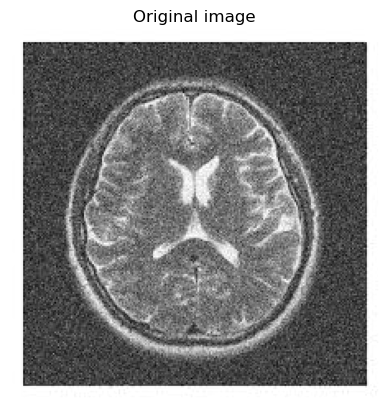

In [3]:
img = img_as_float(io.imread("8.noisyCT.jpg", as_gray=True))
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")
plt.show()

---

### 3) Initial Histogram (Why Thresholding Fails)

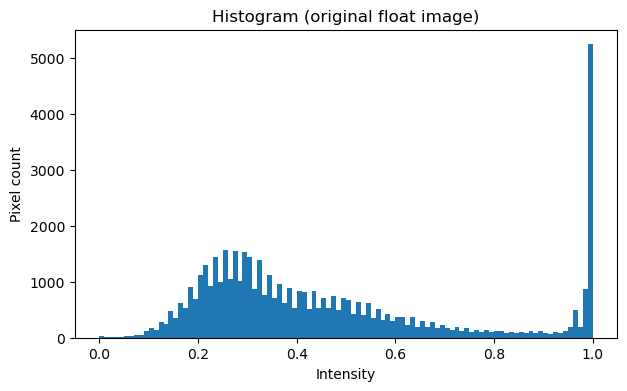

In [4]:
plt.figure(figsize=(7,4))
plt.hist(img.ravel(), bins=100, range=(0,1))
plt.title("Histogram (original float image)")
plt.xlabel("Intensity")
plt.ylabel("Pixel count")
plt.show()

Even if the image has two phases visually, the histogram may not show clean peaks—so simple thresholding is unreliable.

---

### 4) Denoise with Non-Local Means

Non-local means is a great edge-preserving denoiser.

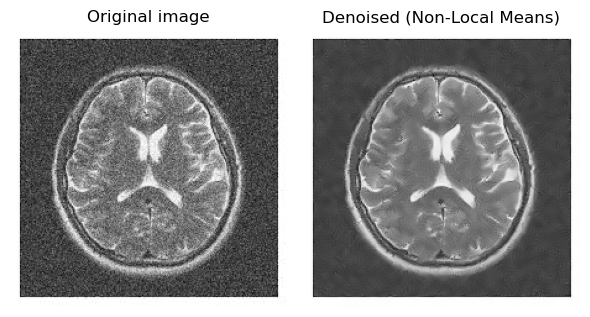

In [11]:
sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
denoised = denoise_nl_means(
    img,
    h= 1.1 * sigma_est,
    patch_size=5,
    patch_distance=3,
    fast_mode=True,      # much faster; can look a bit "cartoonish" sometimes
    channel_axis=None
)

plt.figure(figsize=(6, 7))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = "gray")
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(denoised, cmap = "gray")
plt.axis("off")
plt.title("Denoised (Non-Local Means)")


plt.tight_layout()
plt.show()

**Quick compare histograms**

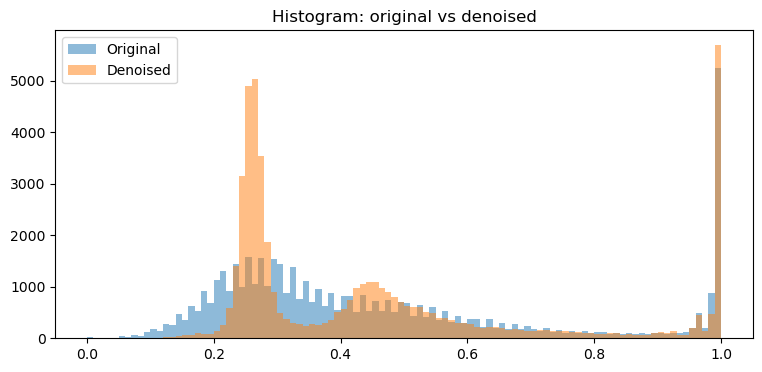

In [15]:
plt.figure(figsize=(9,4))
plt.hist(img.ravel(), bins=100, range=(0,1), alpha=0.5, label="Original")
plt.hist(denoised.ravel(), bins=100, range=(0,1), alpha=0.5, label="Denoised")
plt.title("Histogram: original vs denoised")
plt.legend()
plt.show()

---

### 5) Improve Contrast with CLAHE (Adaptive Histogram Equalization)

Denoising may help but still not enough.   
CLAHE stretches contrast locally so phases are more separable.

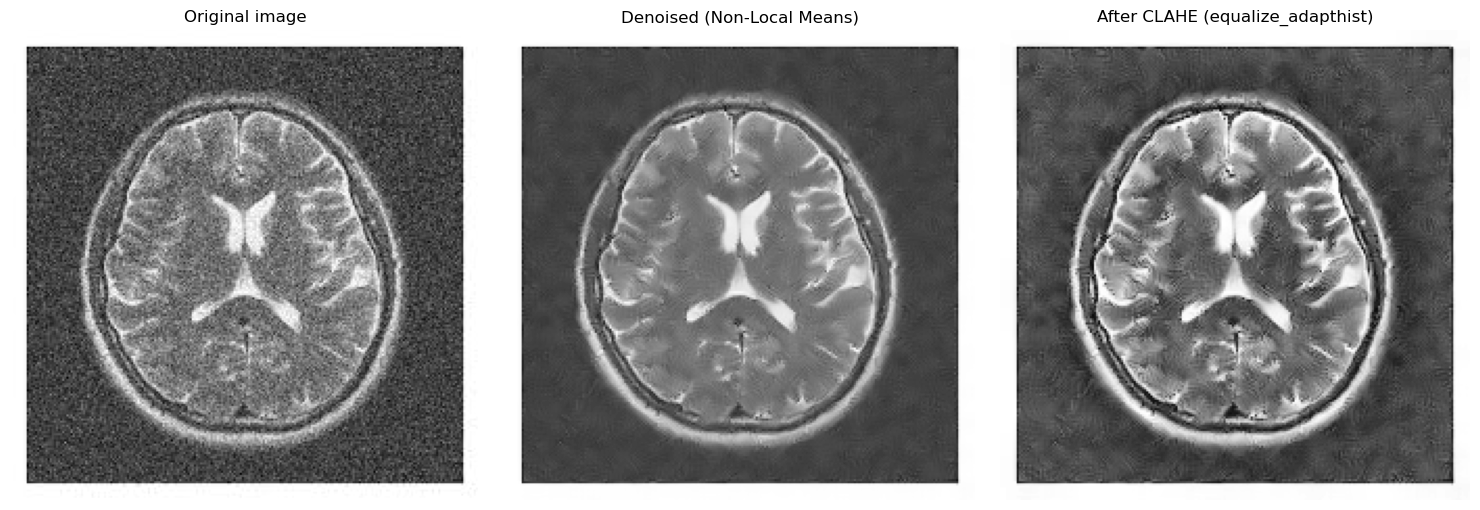

In [20]:
# --- CLAHE (adaptive histogram equalization) ---
eq = exposure.equalize_adapthist(denoised, clip_limit=0.01)

# --- Plot 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(denoised, cmap="gray")
plt.title("Denoised (Non-Local Means)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(eq, cmap="gray")
plt.title("After CLAHE (equalize_adapthist)")
plt.axis("off")

plt.tight_layout()
plt.show()

Histogram after equalization:

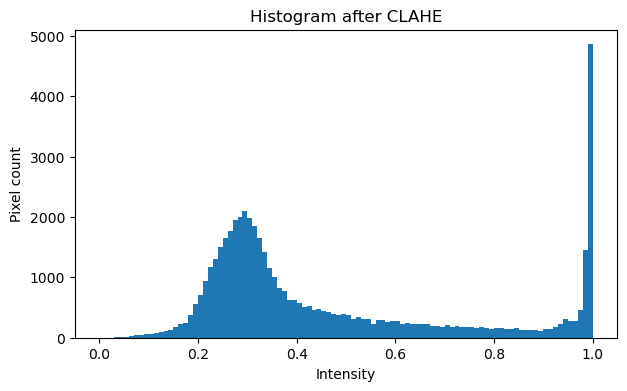

In [21]:
plt.figure(figsize=(7,4))
plt.hist(eq.ravel(), bins=100, range=(0,1))
plt.title("Histogram after CLAHE")
plt.xlabel("Intensity")
plt.ylabel("Pixel count")
plt.show()

> You’ll usually see a wider spread (e.g. 0.3 to 1.0 instead of 0.75 to 0.95).

---

### 6) Create Marker Map (Seeds)

Random walker needs:
- Image (we use eq)
- Markers array of same shape, integer dtype:
    - 0 = unknown/unseeded pixels
    - 1 = seed region for phase A
    - 2 = seed region for phase B

**Pick “high-confidence” intensity bands**
From the transcript:
- Dark phase seeds: 0.3–0.6
- Bright phase seeds: 0.8–0.99

In [22]:
markers = np.zeros(eq.shape, dtype=np.uint8)

markers[(eq > 0.3) & (eq < 0.6)] = 1
markers[(eq > 0.8) & (eq < 0.99)] = 2

Visualize markers:

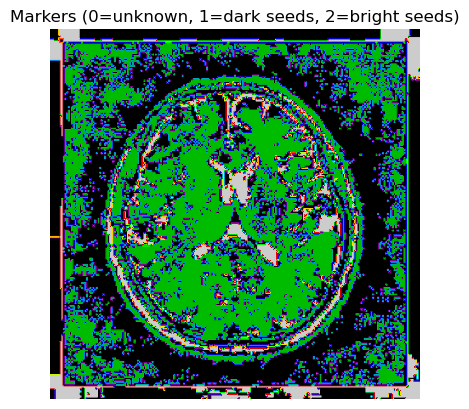

In [23]:
plt.imshow(markers, cmap="nipy_spectral")
plt.title("Markers (0=unknown, 1=dark seeds, 2=bright seeds)")
plt.axis("off")
plt.show()

> ✅ Sanity check: If markers show almost all zeros, your thresholds are too strict.

--- 

### 7) Run Random Walker Segmentation

In [31]:
labels = random_walker(eq, markers, beta=10, mode="bf")

`beta` controls how strongly boundaries are respected:
- higher beta → harder for diffusion to cross edges
- if segmentation “bleeds” across boundaries, increase beta (e.g. 50)
- if it looks fragmented/noisy, decrease beta (e.g. 5)

Display labels:

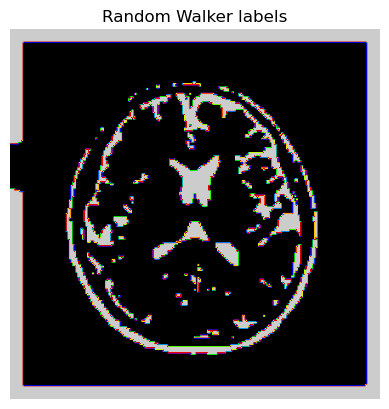

In [32]:
plt.imshow(labels, cmap="nipy_spectral")
plt.title("Random Walker labels")
plt.axis("off")
plt.show()

---

### 8) Convert Labels into Masks + Colored Overlay

In [33]:
seg1 = labels == 1
seg2 = labels == 2

Visualize masks

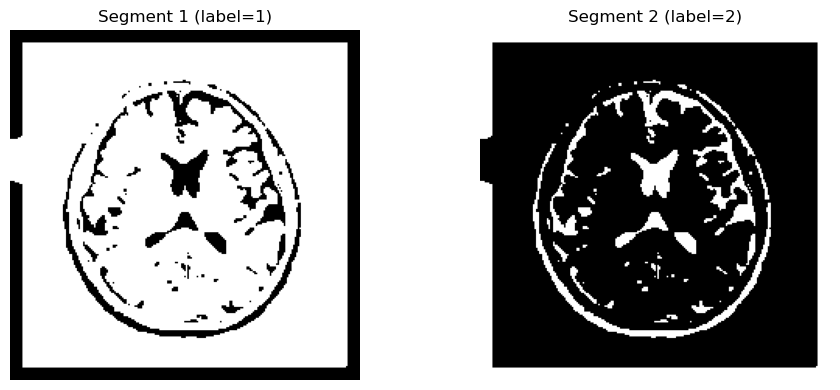

In [34]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(seg1, cmap="gray"); plt.title("Segment 1 (label=1)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(seg2, cmap="gray"); plt.title("Segment 2 (label=2)"); plt.axis("off")
plt.tight_layout()
plt.show()

Make a red/green overlay

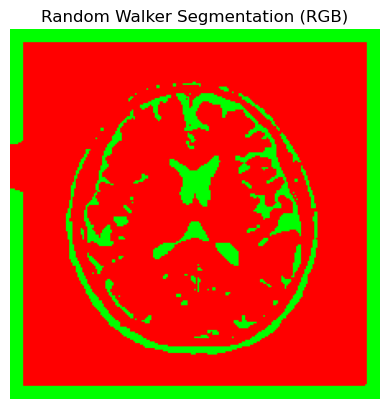

In [35]:
H, W = eq.shape
rgb = np.zeros((H, W, 3), dtype=np.uint8)

rgb[seg1] = (255, 0, 0)   # red
rgb[seg2] = (0, 255, 0)   # green

plt.imshow(rgb)
plt.title("Random Walker Segmentation (RGB)")
plt.axis("off")
plt.show()